**Part A:** Logistic Regression based Natural Language Inference (NLI).

In [1]:
#logging into google colab
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [2]:
#installing dependencies, and importing the required libraries: only for part A
!pip install jsonlines
#importing the jsonl files
import jsonlines  
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import PredefinedSplit, learning_curve
import warnings
import sys
from io import StringIO
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Reading data and finding basic statistics of the data:

*Step 1:* Convert Jsonl file to dictionary of dictionaries

*Step 2:* See the basic statistics and structure of data

In [3]:
#functions to read dataset
def getDataSet_from_jsonl(dataloc):
  #dataset extraction from jsonl files (fields extracted): gold_label (neutral, contradiction, neutral), sentence1 (this is the premise, is assumed to be true), sentence2 (this is the hypothesis: to see if it matches the premise)
  #will extract from the jsonfile and entire dictionary of dictionaries (each internal dictionary will have an example) 
  data_dict = {}
  gold_label = set()
  gold_label_cnt = {}
  with jsonlines.open(dataloc) as fptr:
    index = 0
    for line in fptr.iter():
      #counts the number of examples in each class (there are 4, we only select 3)
      gold_label.add(line['gold_label'])
      if line['gold_label'] in gold_label_cnt:
        gold_label_cnt[line['gold_label']] += 1
      else:
        gold_label_cnt[line['gold_label']] = 1

      #reads the data line by line and returns a dictionary for each line
      #gold_label is the label chosen by majority of annotators (there are some ambigious one where gold label is "-": needs to be excluded)
      if line['gold_label'] != '-':
        data_dict[index] = {}
        data_dict[index]['gold_label'] = line['gold_label']
        data_dict[index]['sentence1'] = line['sentence1']
        data_dict[index]['sentence2'] = line['sentence2'] 
        index += 1

  #displays the count
  for label in gold_label:
    print("Count of label '{}': {}".format(label, gold_label_cnt[label]))
  return data_dict

In [4]:
def getVocab(train_dict):
  stemmer = PorterStemmer()
  stopwords = nltk.corpus.stopwords.words('english')
  vocabulary = set()
  for i in range(len(train_dict)):
    s1 = word_tokenize(train_dict[i]['sentence1'].lower())
    s2 = word_tokenize(train_dict[i]['sentence2'].lower()) 
    for j in range(len(s1)):
      if (s1[j] not in string.punctuation) and (s1[j] not in stopwords):
        vocabulary.add(stemmer.stem(s1[j]))
    for j in range(len(s2)):
      if (s2[j] not in string.punctuation) and (s2[j] not in stopwords):
        vocabulary.add(stemmer.stem(s2[j]))
  
  vocab_dict = {}
  ctr = 0
  for word in vocabulary:
      vocab_dict[word] = ctr
      ctr += 1
  
  return vocab_dict

def getVocab_for_db(dataloc_train, dataloc_test, vocab_req = True):
  
  print("##################Details of train data############################")
  train_dict = getDataSet_from_jsonl(dataloc_train)
  print("Effective size of Train+CV data size (without '-' labels): {} \n Example: {}".format(len(train_dict), train_dict[0]))

  size_train_dict = len(train_dict)
  #permute the train data
  permute_order = np.random.permutation(size_train_dict)
 
  #5% data for cv 
  size_cv_set = int(size_train_dict*0.05)
  size_train_dict -= size_cv_set 

  train_keys = permute_order[0:size_train_dict]
  cv_keys = permute_order[-size_cv_set:]
  
  cv_dict = [train_dict[i] for i in cv_keys]
  train_dict = [train_dict[i] for i in train_keys] 
  test_dict = getDataSet_from_jsonl(dataloc_test)
  
  if vocab_req == True:
    vocabulary = getVocab(train_dict)
    return train_dict, test_dict, cv_dict, vocabulary
  else:
    return train_dict, test_dict, cv_dict


The above statistics exactly match the description given in SNLI. 

Numerical labels map: 

(i) entailment: 0 (ii) contradiction: 1 (iii) Neutral: 2

Convert Data to a structure ready to train a Logistic regression model: TF-IDF features

In [6]:
#Block for converting to TFIDF sparse arrays
def basic_preprocessing(s, stopwords, stemmer):
  s_n = word_tokenize(s.lower())
  
  s_prep = ""
  for i in range(len(s_n)):
    if (s_n[i] not in string.punctuation) and (s_n[i] not in stopwords):
      #adds the key for each word
      s_prep = s_prep+" "+stemmer.stem(s_n[i])
  s_prep = s_prep.strip() 
  #print(s_prep)

  return s_prep

def get_train_TF_IDF_feat(data_dict, vocabulary):
  stopwords = nltk.corpus.stopwords.words('english')
  stemmer = PorterStemmer()
  #this will take the initial dictionary
  X = None
  y = []
  map = {
          'entailment': [1, 0, 0],
          'contradiction': [0, 1, 0],
          'neutral': [0, 0, 1]
        }
  #preparing the corpus
  txt_corpus = []
  #appends in such a way that the 2 sentences are next to one-another
  for itr in range(len(data_dict)):
    s1 = basic_preprocessing(data_dict[itr]['sentence1'], stopwords, stemmer)
    s2 = basic_preprocessing(data_dict[itr]['sentence2'], stopwords, stemmer)
    txt_corpus.append(s1)
    txt_corpus.append(s2)
    #directly stores y as an one-hot vector
    y.append(map[data_dict[itr]['gold_label']])
  y = np.array(y)


  #use the corpus to extract Tfidf features, stop word removal
  tfidf_converter = TfidfVectorizer(vocabulary=vocabulary)
  X = tfidf_converter.fit_transform(txt_corpus)
  word_list = tfidf_converter.get_feature_names_out()

  #indices of sentence 1 and 2
  s1_list = np.arange(y.shape[0])*2
  s2_list = np.arange(y.shape[0])*2 + 1

  X_concat_S1S2 = sparse.hstack((X[s1_list], X[s2_list]), format='csr')

  return tfidf_converter, word_list, X_concat_S1S2, y

#for test/cv data you need to set tfidf features to 0 (for unseen words)
def get_test_TFIDF_projection(data_dict, tfidf_converter):
  stopwords = nltk.corpus.stopwords.words('english')
  stemmer = PorterStemmer()
  X = None
  y = []
  map = {
          'entailment': [1, 0, 0],
          'contradiction': [0, 1, 0],
          'neutral': [0, 0, 1]
        }
  #preparing the corpus
  txt_corpus = []
  for itr in range(len(data_dict)):
    #appends in such a way that the 2 sentences are next to one-another
    s1 = basic_preprocessing(data_dict[itr]['sentence1'], stopwords, stemmer)
    s2 = basic_preprocessing(data_dict[itr]['sentence2'], stopwords, stemmer)
    txt_corpus.append(s1)
    txt_corpus.append(s2)
    #directly stores y as an one-hot vector
    y.append(map[data_dict[itr]['gold_label']])
  y = np.array(y)

  #use the corpus to extract Tfidf features, in the train data space: it will use the feature space as that of the train data
  X = tfidf_converter.transform(txt_corpus)
  
  #indices of sentence 1 and 2
  s1_list = np.arange(y.shape[0])*2
  s2_list = np.arange(y.shape[0])*2 + 1

  X_concat_S1S2 = sparse.hstack((X[s1_list], X[s2_list]), format='csr')

  return X_concat_S1S2, y

In [11]:
def get_train_test_cv(dataloc_train, dataloc_test, data_for_logReg = True):
  
  train_dict, test_dict, cv_dict, vocabulary = getVocab_for_db(dataloc_train, dataloc_test, True)
  #train_dict, test_dict, cv_dict = getVocab_for_db(dataloc_train, dataloc_test, False)
  
  if data_for_logReg == False:
    return train_dict, cv_dict, test_dict

  tfidf_converter, word_list, X_train, y_train = get_train_TF_IDF_feat(train_dict, vocabulary)
  print("The shape of the training data (representation is sparse) (NxD): {} \n Shape of label: {}".format(X_train.shape, y_train.shape))
  
  print("##############################Details of CV data#######################################################")
  print("Effective size of cv data size (without '-' labels): {} \n Example: {}".format(len(cv_dict), cv_dict[0]))
  X_cv, y_cv =  get_test_TFIDF_projection(cv_dict, tfidf_converter)
  print("The shape of the training data (representation is sparse and in the train set space) (NxD): {} \n Shape of label: {}".format(X_cv.shape, y_cv.shape))
  
  print("##############################Details of test data#######################################################")
  print("Effective size of test data size (without '-' labels): {} \n Example: {}".format(len(test_dict), test_dict[0]))
  X_test, y_test =  get_test_TFIDF_projection(test_dict, tfidf_converter)
  print("The shape of the training data (representation is sparse and in the train set space) (NxD): {} \n Shape of label: {}".format(X_test.shape, y_test.shape))

  return X_train, y_train, X_cv, y_cv, X_test, y_test, word_list, vocabulary

X_train, y_train, X_cv, y_cv, X_test, y_test, word_list, vocabulary = get_train_test_cv("gdrive/MyDrive/MachineLearning_E0_270/snli_1.0/snli_1.0_train.jsonl", "gdrive/MyDrive/MachineLearning_E0_270/snli_1.0/snli_1.0_test.jsonl")    
print("Statistics of CV data: {} \n Statistics of test data: {}".format(np.sum(y_cv, axis = 0), np.sum(y_test, axis = 0)))
print("Number of unique words in the list: {}".format(len(word_list)))


##################Details of train data############################
Count of label '-': 785
Count of label 'neutral': 182764
Count of label 'entailment': 183416
Count of label 'contradiction': 183187
Effective size of Train+CV data size (without '-' labels): 549367 
 Example: {'gold_label': 'neutral', 'sentence1': 'A person on a horse jumps over a broken down airplane.', 'sentence2': 'A person is training his horse for a competition.'}
Count of label '-': 176
Count of label 'neutral': 3219
Count of label 'entailment': 3368
Count of label 'contradiction': 3237
The shape of the training data (representation is sparse) (NxD): (521899, 48920) 
 Shape of label: (521899, 3)
##############################Details of CV data#######################################################
Effective size of cv data size (without '-' labels): 27468 
 Example: {'gold_label': 'entailment', 'sentence1': 'A man on a horse throws a lasso at a calf.', 'sentence2': 'A man on a horse.'}
The shape of the training d

In [18]:
#train_dict, test_dict, cv_dict, vocabulary = getVocab_for_db("gdrive/MyDrive/MachineLearning_E0_270/snli_1.0/snli_1.0_train.jsonl", "gdrive/MyDrive/MachineLearning_E0_270/snli_1.0/snli_1.0_test.jsonl")
print(len(vocabulary))
print(vocabulary)

24460
{'petsit': 0, 'fulton': 1, 'maxi-dress': 2, 'turf': 3, 'clearli': 4, 'wateri': 5, 'antipathi': 6, '300': 7, 'dike': 8, 'ng': 9, 'stevedor': 10, 'lounger': 11, 'scrapyard': 12, 'scooter': 13, 'dakota': 14, 'old-styl': 15, 'latt': 16, 'improp': 17, 'fod': 18, 'petroleum': 19, 'resum': 20, 'honeymoon': 21, 'para-surf': 22, 'poorer': 23, 'cycl': 24, 'beautician': 25, 'gase': 26, 'handspr': 27, 'enchilada': 28, '5.40': 29, 'pillo': 30, 'converstaion': 31, 'shut': 32, 'disassembl': 33, 'codpiec': 34, 'undef': 35, 'stow': 36, 'fixer': 37, 'xbox360': 38, 'hare': 39, 'dance-floor': 40, 'hort': 41, 'sittin.g': 42, 'coma': 43, 'dungare': 44, 'cup': 45, 'sap': 46, 'beani': 47, 'tornado': 48, 'potty-potti': 49, 'risk': 50, 'rigidli': 51, 'munchkinland': 52, 'lakeshor': 53, 'unner': 54, 'mountain-dew': 55, 'cheeck': 56, 'costun': 57, 'mohawk': 58, 'unveil': 59, 'mav': 60, 'harrass': 61, 'untidi': 62, 'aparatu': 63, 'fruitstrip': 64, 'lotu': 65, 'sousa': 66, 'iceland': 67, 'truck-ful': 68, 'bro

In [17]:
print(word_list)

['petsit' 'fulton' 'maxi-dress' ... 'blith' 'michigan' 'it.aa']


In [14]:

#logisitc regression model using these TFidf features
def train_softmax_regression(X_train, y_train, X_cv, y_cv, l2_reg, optimizer='lbfgs', max_iter=300):
  #to prevent annoying sklearn warnings
  warnings.filterwarnings('ignore', category=UserWarning, append=True)

  #note sklearn doesn't take one hot encoding for labels hence needs to be converted from 0-2
  y = np.argmax(y_train, axis=1)
  y2 = np.argmax(y_cv, axis=1)

  loss_train = []
  loss_cv = []
  train_acc = []
  cv_acc = []

  softmax_classifier = LogisticRegression(max_iter=1, solver=optimizer, penalty='l2', C=l2_reg, warm_start=True)

  
  for i in range(max_iter):
    softmax_classifier = softmax_classifier.fit(X_train, y)
    #Here incorporate the learning curves.
    prediction_train = softmax_classifier.predict_proba(X_train)
    prediction_cv = softmax_classifier.predict_proba(X_cv)
    #stores the loss function
    loss_train.append(log_loss(y, prediction_train))
    loss_cv.append(log_loss(y2, prediction_cv))
    train_acc.append(test_logistic_model(X_train, y_train, softmax_classifier))
    cv_acc.append(test_logistic_model(X_cv, y_cv, softmax_classifier))    
    if i%40 == 0:
      print("Iteration {}/{}".format(i, max_iter))
      print("loss: {} \n Train accuracy: {} \n CV accuracy: {}".format(loss_train[-1], train_acc[-1], cv_acc[-1]))
  
  return softmax_classifier, loss_train, loss_cv, train_acc, cv_acc

def test_logistic_model(X, y, model):
  return model.score(X, np.argmax(y, axis=1))

**Plotting Learning Curves and Loss curves**

In [15]:
def plot_curve1(pts, x_label, y_label, title):
  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)

  index = np.arange(1, len(pts)+1, 1)
  plt.plot(index, pts, '-b')
  
  plt.show()

def plot_curve2(pts1, pts2, x_label, y_label, title, legend):
  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)

  index = np.arange(1, len(pts1)+1, 1)
  plt.plot(index, pts1, '-b', label=legend[0])
  plt.plot(index, pts2, '-r', label=legend[1])

  plt.legend()
  plt.show()

**Tuning Hyperparameters:**

For logistic regression grid search:

(i) learning rate: [0.0001, 0.001, 0.01, 0.1]

(ii) optimization: SGD (standard optimizers in sklearn.LogisticRegression won't allow epoch wise learning curve)/ ['lbfgs'] 

(iii) regularization: l2 [0.01, 0.1, 1, 2] (SGD regu value higher means more regu, but not in logistic function)

In [ ]:
def tune_hyperparameters_lg_reg(X_train, y_train, X_cv, y_cv):
  solvers = ['lbfgs']
  lambda_val = [0.01, 0.1, 1, 2] #1/lambda is specified as regularization in this dataset
  y = np.argmax(y_train, axis=1)
  y2 = np.argmax(y_cv, axis=1)
  
  len_cv = len(y2)
  X = sparse.vstack((X_train, X_cv), format='csr')
  y = np.append(y, y2)   #this is the label

  test_fold = np.zeros(len(y))
  for i in range(len(y)-len_cv):
    test_fold[i] = -1   #the train is never a part of the validation set (set them all to -1)
  
  
  #parameters for grid search
  grid_region = dict(solver=solvers, penalty=['l2'], C=lambda_val)
  #search for 40 iterations in each case
  hp_tuner_model = LogisticRegression()
  cv_set = PredefinedSplit(test_fold=test_fold)
  grid_search = GridSearchCV(estimator=hp_tuner_model, param_grid=grid_region, cv=cv_set, scoring='accuracy', error_score=0, n_jobs=-1) #for parallel processing
  
  grid_search_result = grid_search.fit(X, y)

  optimizer =  grid_search_result.best_params_['solver']
  l2_reg_val = grid_search_result.best_params_['C']
  print("Best CV accuracy with logistic regression optimizers is {} with:  \n optimizer={} \n lambda(l2) = {}".format(grid_search_result.best_score_, optimizer, l2_reg_val))
   
  return optimizer, l2_reg_val

def tune_hyperparameters_SGD(X_train, y_train, X_cv, y_cv):

  lr = [0.0001, 0.001, 0.01, 0.1]
  lambda_val = [0.01, 0.1, 1, 2] #1/lambda is specified as regularization in this dataset
  y = np.argmax(y_train, axis=1)
  y2 = np.argmax(y_cv, axis=1)
  
  len_cv = len(y2)
  X = sparse.vstack((X_train, X_cv), format='csr')
  y = np.append(y, y2)   #this is the label

  test_fold = np.zeros(len(y))
  for i in range(len(y)-len_cv):
    test_fold[i] = -1   #the train is never a part of the validation set (set them all to -1)
  
  
  #parameters for grid search
  grid_region = dict(alpha=lambda_val, eta0=lr)
  #search for 40 iterations in each case
  hp_tuner_model = SGDClassifier(loss='log', learning_rate='constant') #logistic regression with constant lr
  cv_set = PredefinedSplit(test_fold=test_fold)
  grid_search = GridSearchCV(estimator=hp_tuner_model, param_grid=grid_region, cv=cv_set, scoring='accuracy', error_score=0, n_jobs=-1) #for parallel processing
  
  grid_search_result = grid_search.fit(X, y)

  lr_best =  grid_search_result.best_params_['eta0']
  l2_reg_val = grid_search_result.best_params_['alpha']
  print("Best CV accuracy with SGD is {} with:  \n lr={} \n lambda(l2) = {}".format(grid_search_result.best_score_, lr_best, l2_reg_val))
   
  return lr_best, l2_reg_val


optimizer, l2_reg_val_1 = tune_hyperparameters_lg_reg(X_train, y_train, X_cv, y_cv)
lr_best, l2_reg_val = tune_hyperparameters_SGD(X_train, y_train, X_cv, y_cv)

Best CV accuracy with logistic regression optimizers is 0.6312092833876222 with:  
 optimizer=lbfgs 
 lambda(l2) = 1
Best CV accuracy with SGD is 0.5318607491856677 with:  
 lr=0.001 
 lambda(l2) = 0.01


**Results: PART A (after tuning hyperparameters on the cv set)**
Thus the best optimizer is lbfgs with lambda=1

(i) The following reports loss curves (training curves)

(ii) Learning Curves

(iii) Test set accuracy


Iteration 0/200
loss: 1.0800685419186415 
 Train accuracy: 0.41158538337877637 
 CV accuracy: 0.40654579874763364
Iteration 40/200
loss: 0.9694494987655463 
 Train accuracy: 0.5505854581058788 
 CV accuracy: 0.5462720256298238
Iteration 80/200
loss: 0.9059233201999264 
 Train accuracy: 0.5882402533823594 
 CV accuracy: 0.5845347313237221
Iteration 120/200
loss: 0.8831558340308203 
 Train accuracy: 0.5995163815220953 
 CV accuracy: 0.592034367263725
Iteration 160/200
loss: 0.8618843896392197 
 Train accuracy: 0.6111009984690524 
 CV accuracy: 0.599825251201398
Test Set Accuracy: 0.6170602605863192


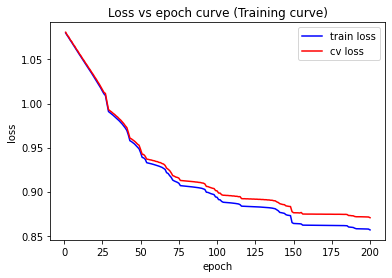

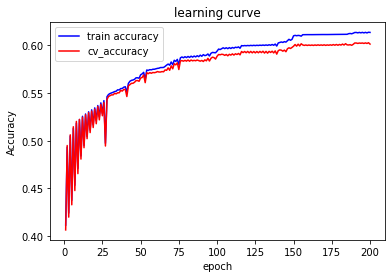

In [19]:
#testing the logistic regression model with the best hyperparameters
#model, loss_train, loss_cv, train_acc, cv_acc = train_softmax_regression(X_train, y_train, X_cv, y_cv, l2_reg_val_1, optimizer, 200)
model, loss_train, loss_cv, train_acc, cv_acc = train_softmax_regression(X_train, y_train, X_cv, y_cv, 1, 'lbfgs', 200)
test_results = test_logistic_model(X_test, y_test, model)
print("Test Set Accuracy: {}".format(test_results))
plot_curve2(loss_train, loss_cv,  "epoch", "loss", "Loss vs epoch curve (Training curve)", ['train loss', 'cv loss'])
plot_curve2(train_acc, cv_acc, "epoch", "Accuracy", "learning curve", ['train accuracy', 'cv_accuracy'])

**B. Deep Learning in NLI: using Tensorflow-keras**

Idea: Since these networks are recurrent in nature, we can use 2 identical sequential blocks, to extract 'features' for each sentence and then at the attend append them to be processed by a few dense layers, only to be finally penalized using the binary cross entropy loss.

Models Used:

(i) RNN

(ii) GRU

(iii) LSTM


In [ ]:
#importing libraries for implementing sequential models
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader, Dataset
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string
import torch.nn.functional as func

**This is the Part for storing the database as pk of words**

In [ ]:
#@title 
#this will read the files and finally
#three case: Pretrained Embeddings (not retrain), Embeddings from scratch
#this does stop word, punctuation removal and stemming
def getVocab_NN(train_dict):
  stemmer = PorterStemmer()
  stopwords = nltk.corpus.stopwords.words('english')
  vocabulary = set()
  for i in range(len(train_dict)):
    s1 = word_tokenize(train_dict[i]['sentence1'].lower())
    s2 = word_tokenize(train_dict[i]['sentence2'].lower()) 
    for j in range(len(s1)):
      if (s1[j] not in string.punctuation) and (s1[j] not in stopwords):
        vocabulary.add(stemmer.stem(s1[j]))
    for j in range(len(s2)):
      if (s2[j] not in string.punctuation) and (s2[j] not in stopwords):
        vocabulary.add(stemmer.stem(s2[j]))
  
  vocab_dict = {}
  ctr = 1 #for unknown words assign 0/ padding
  for word in vocabulary:
      vocab_dict[word] = ctr
      ctr += 1
  
  return vocab_dict


def get_one_hot_Enc(data_dict, vocab_dict):
  s1_index = []
  s2_index = []
  y = []
  label_map = {
          'entailment': 0,
          'contradiction': 1,
          'neutral': 2
        }
  stopwords = nltk.corpus.stopwords.words('english')
  stemmer = PorterStemmer()
  max_l = 0
  for i in range(len(data_dict)):
    s1 = word_tokenize(data_dict[i]['sentence1'].lower())
    s2 = word_tokenize(data_dict[i]['sentence2'].lower()) 
    y.append(label_map[data_dict[i]['gold_label']])
    s1_temp = []
    s2_temp = []
    l1 = 0
    l2 = 0
    for j in range(len(s1)):
      if (s1[j] not in string.punctuation) and (s1[j] not in stopwords):
        #adds the key for each word
        l1 += 1 
        try:
          s1_temp.append(vocab_dict[stemmer.stem(s1[j])])
        except:
          s1_temp.append(0)
    s1_index.append(s1_temp)
    for j in range(len(s2)):
      if (s2[j] not in string.punctuation) and (s2[j] not in stopwords):
        l2 += 1
        try:
          s2_temp.append(vocab_dict[stemmer.stem(s2[j])])
        except:
          #unknown words
          s2_temp.append(0)
    #lenth of the largest string
    if l1>max_l:
      max_l = l1
    if l2>max_l:
      max_l = l2
    s2_index.append(s2_temp)
    
  for i in range(len(data_dict)):
    for j in range(max_l - len(s1_index[i])):
      s1_index[i].insert(0, 0)
    for j in range(max_l - len(s2_index[i])):
      #insert 0s at the beginning  
      s2_index[i].insert(0, 0)
  
  return s1_index, s2_index, y

#this is use for training the own embedding of the words from scratch
def tokenize_sentences(dataloc_train, dataloc_test):
  train_dict, test_dict, cv_dict = getVocab_for_db(dataloc_train, dataloc_test, False)
  #gets the dictionary
  vocab_dict = getVocab_NN(train_dict)

  train_S1, train_S2, train_y = get_one_hot_Enc(train_dict, vocab_dict)
  cv_S1, cv_S2, cv_y = get_one_hot_Enc(cv_dict, vocab_dict)
  test_S1, test_S2, test_y = get_one_hot_Enc(test_dict, vocab_dict)

  max_index = len(vocab_dict)

  return train_S1, train_S2, train_y, cv_S1, cv_S2, cv_y, test_S1, test_S2, test_y, max_index

train_S1, train_S2, train_y, cv_S1, cv_S2, cv_y, test_S1, test_S2, test_y, max_index = tokenize_sentences("gdrive/MyDrive/MachineLearning_E0_270/snli_1.0/snli_1.0_train.jsonl", "gdrive/MyDrive/MachineLearning_E0_270/snli_1.0/snli_1.0_test.jsonl")


In [ ]:
#@title
train_dict, test_dict, cv_dict = getVocab_for_db("gdrive/MyDrive/MachineLearning_E0_270/snli_1.0/snli_1.0_train.jsonl", "gdrive/MyDrive/MachineLearning_E0_270/snli_1.0/snli_1.0_test.jsonl", False)

##################Details of train data############################
Count of label 'entailment': 183416
Count of label 'contradiction': 183187
Count of label '-': 785
Count of label 'neutral': 182764
Effective size of Train+CV data size (without '-' labels): 549367 
 Example: {'gold_label': 'neutral', 'sentence1': 'A person on a horse jumps over a broken down airplane.', 'sentence2': 'A person is training his horse for a competition.'}
Count of label 'entailment': 3368
Count of label 'contradiction': 3237
Count of label '-': 176
Count of label 'neutral': 3219


In [ ]:
#@title
debug_dict = getVocab_NN(train_dict[0:5])
print(debug_dict)
print(train_dict[0:5])

{'curb': 1, 'lift': 2, 'women': 3, 'war': 4, 'play': 5, 'bbq': 6, 'weekend': 7, 'umbrella': 8, 'backyard': 9, 'impeach': 10, 'one': 11, 'dress': 12, 'four': 13, 'happen': 14, 'protest': 15, 'kid': 16, 'woman': 17, 'danc': 18, 'seesaw': 19, 'sit': 20, 'group': 21, 'camera': 22, 'barbecu': 23, 'two': 24, 'man': 25, '2': 26, 'three': 27, 'togeth': 28, 'pink': 29, 'lawn': 30, 'neighborhood': 31, 'men': 32, 'tabl': 33, 'food': 34, 'look': 35, 'grill': 36, 'perform': 37, 'outsid': 38, 'cook': 39, 'basketbal': 40, 'spell': 41, 'joyous': 42, 'stand': 43}
[{'gold_label': 'entailment', 'sentence1': 'War protesters on curb, with pink umbrellas spelling out IMPEACH.', 'sentence2': 'War protesters are on the curb.'}, {'gold_label': 'contradiction', 'sentence1': 'A man lifts up a woman in a pink dress during a dance at a performance.', 'sentence2': 'A man and woman playing basketball.'}, {'gold_label': 'neutral', 'sentence1': 'Four women grouped together, three of them looking at the camera and one 

In [ ]:
#@title
encoded_s1, encoded_s2, y = get_one_hot_Enc(train_dict[0:5], debug_dict)
print(encoded_s1)
print(encoded_s2)
print(y)

[[0, 0, 0, 0, 4, 15, 1, 29, 8, 41, 10], [0, 0, 0, 0, 25, 2, 17, 29, 12, 18, 37], [0, 13, 3, 21, 28, 27, 35, 22, 11, 43, 9], [0, 0, 0, 0, 0, 0, 0, 26, 16, 5, 19], [32, 3, 20, 38, 30, 23, 34, 39, 36, 34, 33]]
[[0, 0, 0, 0, 0, 0, 0, 0, 4, 15, 1], [0, 0, 0, 0, 0, 0, 0, 25, 17, 5, 40], [0, 0, 0, 0, 0, 0, 13, 3, 42, 21, 28], [0, 0, 0, 0, 0, 0, 0, 24, 16, 5, 40], [0, 0, 0, 0, 0, 0, 0, 31, 6, 14, 7]]
[0, 1, 2, 1, 2]


In [ ]:
#write these to google drive for faster access (as converting text to key based values takes 10 minutes)
def write_data_as_index(dataloc, data):
  d_np = np.array(data)
  print(d_np.shape)
  np.save(dataloc, d_np)

write_data_as_index('gdrive/MyDrive/MachineLearning_E0_270/train_S1.npy', train_S1)
write_data_as_index('gdrive/MyDrive/MachineLearning_E0_270/train_S2.npy', train_S2)
write_data_as_index('gdrive/MyDrive/MachineLearning_E0_270/train_y.npy', train_y)
write_data_as_index('gdrive/MyDrive/MachineLearning_E0_270/cv_S1.npy', cv_S1)
write_data_as_index('gdrive/MyDrive/MachineLearning_E0_270/cv_S2.npy', cv_S2)
write_data_as_index('gdrive/MyDrive/MachineLearning_E0_270/cv_y.npy', cv_y)
write_data_as_index('gdrive/MyDrive/MachineLearning_E0_270/test_S1.npy', test_S1)
write_data_as_index('gdrive/MyDrive/MachineLearning_E0_270/test_S2.npy', test_S2)
write_data_as_index('gdrive/MyDrive/MachineLearning_E0_270/test_y.npy', test_y)
print(max_index)

(521899, 45)
(521899, 45)
(521899,)
(27468, 45)
(27468, 45)
(27468,)
(9824, 27)
(9824, 27)
(9824,)
24448


In [ ]:
train_S1 = torch.from_numpy(np.load('gdrive/MyDrive/MachineLearning_E0_270/train_S1.npy'))
train_S2 = torch.from_numpy(np.load('gdrive/MyDrive/MachineLearning_E0_270/train_S2.npy'))
train_y = torch.from_numpy(np.load('gdrive/MyDrive/MachineLearning_E0_270/train_y.npy'))
cv_S1 = torch.from_numpy(np.load('gdrive/MyDrive/MachineLearning_E0_270/cv_S1.npy'))
cv_S2 = torch.from_numpy(np.load('gdrive/MyDrive/MachineLearning_E0_270/cv_S2.npy'))
cv_y = torch.from_numpy(np.load('gdrive/MyDrive/MachineLearning_E0_270/cv_y.npy'))
test_S1 = torch.from_numpy(np.load('gdrive/MyDrive/MachineLearning_E0_270/test_S1.npy'))
test_S2 = torch.from_numpy(np.load('gdrive/MyDrive/MachineLearning_E0_270/test_S2.npy'))
test_y = torch.from_numpy(np.load('gdrive/MyDrive/MachineLearning_E0_270/test_y.npy'))
max_index = 24448

In [ ]:
print(train_S2[1510])

tensor([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0, 1738, 9259, 1329])


**Neural Net code for code: This section of the code has been experimented in the server**

In [ ]:
#@title
#RNNs (Recurrent Neural Network)
class RNN(nn.Module):
  #initializer
  #this contains input_layer size (length of the word embeddings: Here word2vec/embedding layers),
  def __init__(self, vocab_size, input_size, hidden_size, fc_size, num_layers, num_labels, dropout_rnn, dropout_fc):
    #construct the parent
    super(RNN, self).__init__()
    #all information about the RNN stored
    self.input_size = input_size
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    #number of classes in the classification problem
    self.num_labels = num_labels
    #embeddings are of the shape (vocab_size-->150: standard size is 300 for 4B words)
    self.Emb_layer = nn.Embedding(vocab_size, input_size, padding_idx=0)
    #from the torch.nn module we initialize an rnn object (if multiple stacked RNNs are present num_layers is used)
    #batch first is done in accordance to keras convention of (None, sentence length, word_emb-size
    self.rnn_s1 = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout_rnn)
    self.rnn_s2 = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout_rnn)
    #concatenate outputs of network 1 and 2 and then define a fully connected layer followed by softmax classification
    #fully connected layer: (taking the input from both the recurrent unit)
    self.fully_connected_1 = nn.Linear(2*hidden_size, fc_size)
    self.fc_dropout = nn.Dropout(dropout_fc)
    self.fully_connected_2 = nn.Linear(fc_size, num_labels)

  #idea of py-torch: keep all the components ready, an link them while overriding forward
  #forward propagation definition: process the sentences differently
  def forward(self, s1, s2):
    #data for the inputs is of the form (num_layers, batch_size, output_size)


    #s1_tensor = torch.tensor(s1, dtype=torch.long)
    #s2_tensor = torch.tensor(s2, dtype=torch.long)
    #embeddings = self
    s1_emb = self.Emb_layer(s1)
    s2_emb = self.Emb_layer(s2)
    out_s1, _ = self.rnn_s1(s1_emb)    # a0)
    #storing only the output of the last timestamp
    out_s1 = out_s1[:, -1, :]
    #output is of (batch_size, sentence_l, output) -> just need the last o/p (as a feature for the sentence)
    out_s2, _ = self.rnn_s2(s2_emb)   #a0)
    out_s2 = out_s2[:, -1, :]

    #desired output is of the form (batch_size, (f_s1+f_s2))
    input_fc = torch.cat((out_s1, out_s2), dim=1)
    #gives y=Ax+b, to be passed through cross entropy loss in pytorch to get softmax classifier
    output_fc1 = func.relu(self.fully_connected_1(input_fc))
    output_dropout = self.fc_dropout(output_fc1)
    output_nn = self.fully_connected_2(output_dropout)
    return output_nn
##########################################################################################################################################################

#LSTM (long short term memory)
class LSTM(nn.Module):
  #initializer
  #this contains input_layer size (length of the word embeddings: Here word2vec/embedding layers),
  def __init__(self, vocab_size, input_size, hidden_size, fc_size, num_layers, num_labels, dropout_rnn, dropout_fc):
    super(LSTM, self).__init__()
    #all information about the RNN stored
    self.input_size = input_size
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    #number of classes in the classification problem
    self.num_labels = num_labels
    #embeddings are of the shape (vocab_size-->150: standard size is 300 for 4B words)
    self.Emb_layer = nn.Embedding(vocab_size, input_size, padding_idx=0)
    #from the torch.nn module we initialize an rnn object (if multiple stacked RNNs are present num_layers is used)
    #batch first is done in accordance to keras convention of (None, sentence length, word_emb-size
    self.lstm_s1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout_rnn)
    self.lstm_s2 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout_rnn)
    #concatenate outputs of network 1 and 2 and then define a fully connected layer followed by softmax classification
    #fully connected layer: (taking the input from both the recurrent unit)
    self.fully_connected_1 = nn.Linear(2*hidden_size, fc_size)
    self.fc_dropout = nn.Dropout(dropout_fc)
    self.fully_connected_2 = nn.Linear(fc_size, num_labels)

  #idea of py-torch: keep all the components ready, an link them while overriding forward
  #forward propagation definition: process the sentences differently
  def forward(self, s1, s2):
    #data for the inputs is of the form (num_layers, batch_size, output_size)
    #s1_tensor = torch.tensor(s1, dtype=torch.long)
    #s2_tensor = torch.tensor(s2, dtype=torch.long)
    #embeddings = self
    s1_emb = self.Emb_layer(s1)
    s2_emb = self.Emb_layer(s2)
    out_s1, _ = self.lstm_s1(s1_emb) #(a0, c0))
    #print(out_s1.shape)
    #storing only the output of the last timestamp (outputs are of the form: [batch, Sequence_l, hidden size])
    out_s1 = out_s1[:, -1, :]
    #print(out_s1.shape)
    #output is of (batch_size, sentence_l, output) -> just need the last o/p (as a feature for the sentence)
    out_s2, _ = self.lstm_s1(s2_emb) #(a0, c0))
    #print(out_s2.shape)
    out_s2 = out_s2[:, -1, :]
    #print(out_s2.shape)
    #desired output is of the form (batch_size, (f_s1+f_s2))
    input_fc = torch.cat((out_s1, out_s2), dim=1)
    #print(input_fc.shape)
    #gives y=Ax+b, to be passed through cross entropy loss in pytorch to get softmax classifier
    output_fc1 = func.relu(self.fully_connected_1(input_fc))
    #print(output_fc1.shape)
    output_dropout = self.fc_dropout(output_fc1)
    #print(output_dropout.shape)
    output_nn = self.fully_connected_2(output_dropout)
    #print(output_nn.shape)
    return output_nn

###############################################################################################################################################################


In [ ]:
#@title
#dataset formation class
class get_dataset(Dataset):
  def __init__(self, s1, s2, y):
    self.S1 = s1
    self.S2 = s2
    self.y = y 
  def __len__(self):
    return len(self.y)

  def __getitem__(self, index):
    #overriding this function to get batch
    #or do some preprocessing like converting to word to vec/embeddig layer
    S1 = self.S1[index]
    S2 = self.S2[index]
    y = self.y[index]
    return S1, S2, y

#this will act as a general caller for all the Deep Sequential models
def SequentialModel_Driver(model_name, hyperparameters):

  #convert the datasets in the desired form
  train_set = get_dataset(train_S1, train_S2, train_y)
  cv_set = get_dataset(cv_S1, cv_S2, cv_y)
  test_set = get_dataset(test_S1, test_S2, test_y)
  #sees if cuda device is present
  print(torch.cuda.is_available())
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  print(device)

  #initialize the batch maker and shuffler
  batch_maker = DataLoader(dataset=train_set, batch_size=hyperparameters['batch_size'], shuffle=True, drop_last=True)
  batch_maker_cv = DataLoader(dataset=cv_set, batch_size=hyperparameters['batch_size'], shuffle=True, drop_last=True)
  #initialize the model
  model = None
  if model_name == "RNN":
    #+1 for unknown words
    model = RNN(max_index+1, hyperparameters['input_size'], hyperparameters['hidden_size'], 2, hyperparameters['num_layers'], hyperparameters['num_labels'], 0.55, 0.71)
  if model_name == "LSTM":
    #+1 for unknown words
    model = LSTM(max_index+1, hyperparameters['input_size'], hyperparameters['hidden_size'], 2, hyperparameters['num_layers'], hyperparameters['num_labels'], 0.55, 0.71)
  model = model.to(device)

  #initialize the hyperparameters
  optimizer = None
  loss_func = nn.CrossEntropyLoss()
  if hyperparameters['optimizer'] == "Adam":
   optimizer = Adam(model.parameters(), lr=hyperparameters['learning_rate'])

  train_acc = []
  train_loss = []
  cv_accuracy = []
  cv_loss = []
  #running iterative optimization
  for epoch_num in tqdm(range(hyperparameters['num_epochs'])):
    #gives us batches of the desired size
    for train_batch_X_S1, train_batch_X_S2, train_batch_y in batch_maker:

      #send the data to the gpu
      train_batch_X_S1, train_batch_X_S2, train_batch_y = train_batch_X_S1.to(device), train_batch_X_S2.to(device), train_batch_y.to(device)
      #feed the data to the network
      y_hat = model(train_batch_X_S1, train_batch_X_S2) # a0)
      mini_batch_loss = loss_func(y_hat, train_batch_y)

      #backpropapagate the loss to learn the model
      optimizer.zero_grad()
      #all the gradients are set to 0 so that it doesn't accumulate (the add up in pytorch)
      mini_batch_loss.backward()
      #compute the gradients and update the weights
      optimizer.step()

    #calculating the results on the cv set and train set after each epoch
    with torch.set_grad_enabled(False):
      loss = 0
      n_correct = 0
      for cv_batch_X_S1, cv_batch_X_S2, cv_batch_y in batch_maker_cv:
        cv_batch_X_S1, cv_batch_X_S2, cv_batch_y = cv_batch_X_S1.to(device), cv_batch_X_S2.to(device), cv_batch_y.to(device)
       
        #feed the data to the network
        y_hat = model(cv_batch_X_S1, cv_batch_X_S2)  #a0)
        
        mini_batch_loss = loss_func(y_hat, cv_batch_y)
        loss += mini_batch_loss*(cv_batch_y.size(0)/(len(cv_y)))
        #property of softmax: max of the labels is selected (it is monotonic)
        #max per column (1st index is the maxval, 2nd is the argmax)
        _, predict_y = torch.max(y_hat.data, 1)
        
        n_correct += ((predict_y == cv_batch_y).sum().item())
       
        
      cv_accuracy.append(n_correct/len(cv_y))
      cv_loss.append(loss)

      loss = 0
      n_correct = 0
      for train_batch_X_S1, train_batch_X_S2, train_batch_y in batch_maker:
        train_batch_X_S1, train_batch_X_S2, train_batch_y = train_batch_X_S1.to(device), train_batch_X_S2.to(device), train_batch_y.to(device)

        #feed the data to the network
        y_hat = model(train_batch_X_S1, train_batch_X_S2)   #a0)
      
        mini_batch_loss = loss_func(y_hat, train_batch_y)
        loss += mini_batch_loss*(train_batch_y.size(0)/(len(train_y)))

        _, predict_y = torch.max(y_hat.data, 1)
        n_correct += ((predict_y == train_batch_y).sum().item())
        
      train_acc.append(n_correct/len(train_y))
      train_loss.append(loss)
  
  return train_loss, train_acc, cv_loss, cv_accuracy

In [ ]:
#@title
#this will act as a general caller for all the Deep Sequential models
def SequentialModel_hp_tuner(self, model, optim_name, train_S1, train_S2, train_y, cv_s1, cv_S1, cv_S2, hyp_sugg, hyp_non_opt):
  #convert the datasets in the desired form
  train_set = get_dataset(train_S1, train_S2, train_y)
  cv_set = get_dataset(cv_S1, cv_S2, cv_y)
  #sees if cuda device is present
  print(torch.cuda.is_available())
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  print(device)

  #initialize the batch maker and shuffler
  batch_maker = DataLoader(dataset=train_set, batch_size=hyp_non_opt['batch_size'], shuffle=True, drop_last=True)
  batch_maker_cv = DataLoader(dataset=cv_set, batch_size=hyp_non_opt['batch_size'], shuffle=True, drop_last=True)
  
  model = model.to(device)
  a0 = torch.zeros(model.num_layers, hyp_non_opt['batch_size'], model.hidden_size, device=device)
  a0 = a0.to(device)
  #initialize the hyperparameters  
  loss_func = nn.CrossEntropyLoss()
  if optim_name == "adam":
    optimizer = Adam(model.parameters(), 
                    lr=self.suggest_float("learning_rate", hyp_sugg['learning_rate'][0], hyp_sugg['learning_rate'][0],  log=True),
                    weight_decay = self.suggest_float("l2_reg", hyp_sugg['l2_reg'][0], hyp_sugg['l2_reg'][0],  log=True))
  elif optim_name == "sgd":
    optimizer = SGD(model.parameters(), 
                    lr=self.suggest_float("learning_rate", hyp_sugg['learning_rate'][0], hyp_sugg['learning_rate'][0],  log=True),
                    weight_decay = self.suggest_float("l2_reg", hyp_sugg['l2_reg'][0], hyp_sugg['l2_reg'][0],  log=True))
  cv_acc = 0
  #running iterative optimization
  for epoch_num in tqdm(range(hyp_non_opt['num_epochs'])):
    #gives us batches of the desired size
    for train_batch_X_S1, train_batch_X_S2, train_batch_y in batch_maker:

      #send the data to the gpu
      train_batch_X_S1, train_batch_X_S2, train_batch_y = train_batch_X_S1.to(device), train_batch_X_S2.to(device), train_batch_y.to(device)
      #feed the data to the network
      y_hat = model(train_batch_X_S1, train_batch_X_S2, a0)
      mini_batch_loss = loss_func(y_hat, train_batch_y)

      #backpropapagate the loss to learn the model
      optimizer.zero_grad()
      #all the gradients are set to 0 so that it doesn't accumulate (the add up in pytorch)
      mini_batch_loss.backward()
      #compute the gradients and update the weights
      optimizer.step()

    #calculating the results on the cv
  with torch.set_grad_enabled(False):
    n_correct = 0
    for cv_batch_X_S1, cv_batch_X_S2, cv_batch_y in batch_maker_cv:
      cv_batch_X_S1, cv_batch_X_S2, cv_batch_y = cv_batch_X_S1.to(device), cv_batch_X_S2.to(device), cv_batch_y.to(device)
       
      #feed the data to the network
      y_hat = model(cv_batch_X_S1, cv_batch_X_S2, a0)
        
      #property of softmax: max of the labels is selected (it is monotonic)
      #max per column (1st index is the maxval, 2nd is the argmax)
      _, predict_y = torch.max(y_hat.data, 1)
        
      n_correct += ((predict_y == cv_batch_y).sum().item())
       
        
      cv_acc = n_correct/len(cv_y)
      
  return cv_acc

In [ ]:
#@title
def optimize_hyperparameters(self, vocab_size, train_S1, train_S2, train_y, cv_s1, cv_S1, cv_S2, model_name, optim_name, hyp_sugg, hyp_non_opt):
    import gc
    import optuna as opt
    
    cv_acc = 0
    #has all the keys to the hyper_parameter suggestion
    hyp_keys = list(hyp_sugg.keys())

    #ideally a general form of suggest trials: self.suggest_float(hyp_keys[i], hyp_sugg[hyp_keys[i]][0], hyp_sugg[hyp_keys[i]][1], log=True) \forall i \in len(hyp_keys)
    #required form of string: model =  model_name(self.suggest_float("l2_dense", hyp['l2_dense'][0], hyp['l2_dense'][1]), self.suggest_float("l2_conv", hyp['l2_conv'][0], hyp['l2_conv'][1]), self.suggest_float("dropout", hyp['dropout'][0], hyp['dropout'][1]), self.suggest_float("l2_emb", hyp['l2_emb'][0], hyp['l2_emb'][1]),  num_sub, dim)
    model = None
    #order of parameters: vocab_size, input_size, hidden_size, fc_size, num_layers, num_labels, dropout_rnn, dropout_fc, bi_direct
    if model_name == 'RNN':
      model = RNN(hyp_non_opt['vocab_size'], 
                  self.suggest_categorical("emb_size", hyp_sugg['emb_size']), 
                  self.suggest_categorical("hidden_size", hyp_sugg['hidden_size']), 
                  self.suggest_categorical("fc_size", hyp_sugg['fc_size']), 
                  self.suggest_categorical("num_layers", hyp_sugg['num_layers']), 
                  hyp_non_opt['num_labels'], 
                  self.suggest_float("dropout_rnn", hyp_sugg['dropout_rnn'][0], hyp_sugg['dropout_rnn'][1]), 
                  self.suggest_float("dropout_fc", hyp_sugg['dropout_fc'][0], hyp_sugg['dropout_fc'][1]),
                  self.suggest_categorical("bidirect", hyp_sugg['bidirect']))
    #after execution 'model' will have the entire hyperparameter optuna form

    #compiles the model
    cv_acc = SequentialModel_hp_tuner(self, model, optim_name, train_S1, train_S2, train_y, cv_s1, cv_S1, cv_S2, hyp_sugg, hyp_non_opt)
    gc.collect()

    return cv_acc

#learning rates, choice of optimizers, number of layers, number of units in each layer, regularization
def hyperparameter_tuner(vocab_size, train_S1, train_S2, train_y, cv_s1, cv_S1, cv_S2, model_name, hyp_saveloc):

    hyp_sugg = {'learning_rate': [1e-6, 0.1],
                'l2_reg': [0.001, 0.5],
                'dropout_rnn': [0.2, 0.8],
                'dropout_fc': [0.2, 0.9],
                'optimizer': ['sgd', 'adam'],
                'num_layers': [1, 2, 3],
                'hidden_size': [64, 128, 256],
                'fc_size': [32, 64, 128],
                'bidirect': [True, False],
                'emb_size': [100, 160, 240, 300] 
                }
    hyp_non_opt = {'vocab_size': vocab_size+1, 
                     'batch_size': 128,
                      'num_labels': 3,
                      'num_epochs': 10
                     }
    for optim_name in hyp_sugg['optimizer']:
      #This is to get exact hyperparameter
      hyperparameters = {}

      #This is to pass models dynamically
      objective = lambda self: optimize_hyperparameters(self,  hyp_non_opt['vocab_size'], train_S1, train_S2, train_y, cv_s1, cv_S1, cv_S2, model_name, optim_name, hyp_sugg, hyp_non_opt)

      #maximize the cross validation accuracy
      optimizer = opt.create_study(sampler=opt.samplers.TPESampler(), direction='maximize')
      #number of trials = 50, and garbage collection is set to true
      optimizer.optimize(objective, n_trials=25, timeout=None, gc_after_trial=True)
      #The best params class member is a dict of best params
      hyperparameters = optimizer.best_params
      cv_acc_max = optimizer.best_value
      print("for optimizer: {} cv accuracy maximized to {} with following hyperparameters: ".format(optim_name, cv_acc_max), file=hyp_saveloc)
      print(hyperparameters, file=hyp_saveloc)
      print("---------------------------------------------------------------------------", file=hyp_saveloc)

In [ ]:
#@title
hyperparameters = {'input_size': 150,
                   'hidden_size': 256,
                   'num_layers': 2, 
                   'learning_rate': 0.001,
                   'bi_direct': False,
                   'num_epochs': 3,
                   'optimizer': "Adam",
                   'num_labels': 3,
                   'batch_size': 128
                   }
!export CUDA_LAUNCH_BLOCKING=1                 
train_loss, train_acc, cv_loss, cv_accuracy = SequentialModel_Driver("LSTM", hyperparameters)

True
cuda:0


100%|██████████| 3/3 [28:57<00:00, 579.06s/it]


In [ ]:
#@title
#LSTM (long short term memory)
class LSTM(nn.Module):
  #initializer
  #this contains input_layer size (length of the word embeddings: Here word2vec/embedding layers),
  def __init__(self, vocab_size, input_size, hidden_size, fc_size, num_layers, num_labels, dropout_rnn, dropout_fc):
    #construct the parent
    super(LSTM, self).__init__()
    #all information about the RNN stored
    self.input_size = input_size
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    #number of classes in the classification problem
    self.num_labels = num_labels
    #embeddings are of the shape (vocab_size-->150: standard size is 300 for 4B words)
    self.Emb_layer = nn.Embedding(vocab_size, input_size, padding_idx=0)
    #from the torch.nn module we initialize an rnn object (if multiple stacked RNNs are present num_layers is used)
    #batch first is done in accordance to keras convention of (None, sentence length, word_emb-size
    self.lstm_s1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout_rnn)
    self.lstm_s2 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout_rnn)
    #concatenate outputs of network 1 and 2 and then define a fully connected layer followed by softmax classification
    #fully connected layer: (taking the input from both the recurrent unit)
    self.fully_connected_1 = nn.Linear(2*hidden_size, fc_size)
    self.fc_dropout = nn.Dropout(dropout_fc)
    self.fully_connected_2 = nn.Linear(fc_size, num_labels)

  #idea of py-torch: keep all the components ready, an link them while overriding forward
  #forward propagation definition: process the sentences differently
  def forward(self, s1, s2, a0, c0):
    #data for the inputs is of the form (num_layers, batch_size, output_size)


    #s1_tensor = torch.tensor(s1, dtype=torch.long)
    #s2_tensor = torch.tensor(s2, dtype=torch.long)
    #embeddings = self
    s1_emb = self.Emb_layer(s1)
    s2_emb = self.Emb_layer(s2)
    out_s1, _ = self.lstm_s1(s1_emb) #(a0, c0))
    #storing only the output of the last timestamp (outputs are of the form: [batch, Sequence_l, hidden size])
    out_s1 = out_s1[:, -1, :]
    #output is of (batch_size, sentence_l, output) -> just need the last o/p (as a feature for the sentence)
    out_s2, _ = self.lstm_s2(s2_emb) 
    print(out_s2)#(a0, c0))
    out_s2 = out_s2[:, -1, :]

    #desired output is of the form (batch_size, (f_s1+f_s2))
    input_fc = torch.cat((out_s1, out_s2), dim=1)
    #gives y=Ax+b, to be passed through cross entropy loss in pytorch to get softmax classifier
    output_fc1 = self.fully_connected_1(input_fc)
    output_dropout = self.fc_dropout(output_fc1)
    output_nn = self.fully_connected_2(output_dropout)
    return output_nn

In [ ]:
#@title
def SequentialModel_hp_tuner(model_name, model, optimizer, train_S1, train_S2, train_y, cv_S1, cv_S2, cv_y, hyp_sugg, hyp_non_opt, device_id):
  #convert the datasets in the desired form
  train_set = get_dataset(train_S1, train_S2, train_y)
  cv_set = get_dataset(cv_S1, cv_S2, cv_y)
  #sees if cuda device is present
  print(torch.cuda.is_available(), torch.cuda.device_count())
  device = torch.device('cuda:'+str(device_id) if torch.cuda.is_available() else 'cpu')
  print(device)

  #initialize the batch maker and shuffler
  batch_maker = DataLoader(dataset=train_set, batch_size=hyp_non_opt['batch_size'], shuffle=True, drop_last=True)
  batch_maker_cv = DataLoader(dataset=cv_set, batch_size=hyp_non_opt['batch_size'], shuffle=True, drop_last=True)


  model = model.to(device)
  a0 = torch.zeros(model.num_layers, hyp_non_opt['batch_size'], model.hidden_size, device=device)
  a0 = a0.to(device)

  c0 = torch.zeros(model.num_layers, hyp_non_opt['batch_size'], model.hidden_size, device=device)
  c0 = c0.to(device)
  loss_func = nn.CrossEntropyLoss()
  #running iterative optimization
  for epoch_num in tqdm(range(hyp_non_opt['num_epochs'])):
    #gives us batches of the desired size
    for train_batch_X_S1, train_batch_X_S2, train_batch_y in batch_maker:

      #send the data to the gpu
      train_batch_X_S1, train_batch_X_S2, train_batch_y = train_batch_X_S1.to(device), train_batch_X_S2.to(device), train_batch_y.to(device)
      #feed the data to the network
      y_hat = None
      if model_name == 'LSTM':
        y_hat = model(train_batch_X_S1, train_batch_X_S2, a0, c0)
      else:
        y_hat = model(train_batch_X_S1, train_batch_X_S2, a0)

      mini_batch_loss = loss_func(y_hat, train_batch_y)

      #backpropapagate the loss to learn the model
      optimizer.zero_grad()
      #all the gradients are set to 0 so that it doesn't accumulate (the add up in pytorch)
      mini_batch_loss.backward()
      #compute the gradients and update the weights
      optimizer.step()

    #calculating the results on the cv
  with torch.set_grad_enabled(False):
    n_correct = 0
    for cv_batch_X_S1, cv_batch_X_S2, cv_batch_y in batch_maker_cv:
      cv_batch_X_S1, cv_batch_X_S2, cv_batch_y = cv_batch_X_S1.to(device), cv_batch_X_S2.to(device), cv_batch_y.to(device)

      #feed the data to the network
      y_hat = model(cv_batch_X_S1, cv_batch_X_S2, a0)

      #property of softmax: max of the labels is selected (it is monotonic)
      #max per column (1st index is the maxval, 2nd is the argmax)
      _, predict_y = torch.max(y_hat.data, 1)
      n_correct += ((predict_y == cv_batch_y).sum().item())


      cv_acc = n_correct/len(cv_y)

  return cv_acc


In [ ]:
#@title
model = LSTM(max_index+1, 100, 256, 128, 1, 3, 0.5, 0.6)
optimizer = Adam(model.parameters(), lr=0.01, weight_decay = 0.05)

In [ ]:
#@title
cv_acc = SequentialModel_hp_tuner("LSTM", model, optimizer, train_S1, train_S2, train_y, cv_S1, cv_S2, cv_y, None, {'batch_size': 128, 'num_epochs': 2}, 0)

In [ ]:
#@title
def get_packed_batch(X):
  p_S = []
  #find the length of each sentence and return packed sequence
  l_S = []  
  max_l_S = 0
  for i in range(X.shape[0]):
    temp_s = None
    ctr = X.shape[1]
    for j in range(X.shape[1]):  
      if X[i, j] != 0:
        p_S.append(X[i, j:].numpy())
        l_S.append(ctr)
        if ctr>max_l_S:
          max_l_S = ctr
        break
      else:
        ctr -= 1

  p_S_r = np.array([]).reshape((0, max_l_S))
  for i in range(len(p_S)):
    t = np.concatenate((p_S[i], np.zeros(max_l_S - l_S[i]))).reshape((1, max_l_S))
    p_S_r = np.append(p_S_r, t, axis=0)
  
  #print(torch.from_numpy(p_S_r)[0:4])
  print(p_S_r)
  l_S = np.array(l_S)
  print(l_S)
  sort_index = np.argsort(-l_S, kind='stable')
  l_S = l_S[sort_index]
  
  p_S_r = p_S_r[sort_index]

  return torch.from_numpy(p_S_r), l_S, np.argsort(sort_index, kind='stable'), max_l_S


In [ ]:
#@title
p_S, l_S, sorted_index, max_l_S = get_packed_batch(train_S2[0:128])
print(p_S)
print(len(l_S))
print(max_l_S)
print(l_S[sorted_index])
print(sorted_index)

[[ 1733. 20792.   867. ...     0.     0.     0.]
 [17479.  1469. 12312. ...     0.     0.     0.]
 [22468. 23000. 14036. ...     0.     0.     0.]
 ...
 [15576.    24.     0. ...     0.     0.     0.]
 [16892. 17679.  3988. ...     0.     0.     0.]
 [ 7962. 12987. 17284. ...     0.     0.     0.]]
[ 3  5  4  2  8  5  3 13  7  3  4  4  4  5  2  4  4  2  3  5 11  3  4  3
  3  3  3  3  5  3  7  4  4  6  2  4  8  3  3  3  3  4  3  3  3  3  7  6
  4  6  4  3  2  3  4  3  5  4  3  4  2  4  4  3  4  6  6  4  5  4  4  5
  2  3  4  2  7  4  2  6  3  3  6  3  2  3  3  4  3  2  2  3  2  5  3  4
  3  2  6  2  9  6  6  4  3  4  3  5  5  6  5  5  6  2  3  4  2  6  2  2
  4  6  4  3  2  2  4  3]
tensor([[19405.,  1201.,  7962.,  ..., 17284., 16156., 14924.],
        [16738.,  1469., 22761.,  ...,  2529.,     0.,     0.],
        [16892., 22761.,  6985.,  ...,     0.,     0.,     0.],
        ...,
        [ 1469.,  3488.,     0.,  ...,     0.,     0.,     0.],
        [17882.,  2529.,     0.,  ...,  

In [ ]:
#@title
p_S[sorted_index]

tensor([[18816., 16263., 22761.,  ...,     0.,     0.,     0.],
        [ 3789., 12312., 13458.,  ...,     0.,     0.,     0.],
        [15576., 20032., 17979.,  ...,     0.,     0.,     0.],
        ...,
        [ 5119., 15576., 22712.,  ...,     0.,     0.,     0.],
        [16892.,  3730., 16892.,  ...,     0.,     0.,     0.],
        [ 7962.,  3730., 11853.,  ...,     0.,     0.,     0.]],
       dtype=torch.float64)

In [ ]:
#@title
X = np.array([1, 3, 4, 2])
y = [0, 3, 1, 2]
print(X[y][y])

[1 4 2 3]


**Word2Vec Embeddings**

In [ ]:
import gensim
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api
emb_w2v = api.load("word2vec-google-news-300")
emb_glove = api.load("glove-wiki-gigaword-100")

[==================================================] 100.0% 1662.8/1662.8MB downloaded
[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
v1 = emb_w2v['machine'].reshape(300, 1)
v2 = emb_glove['machine'].reshape(100, 1)
np.append(v1, v2, axis=0).shape

(400, 1)

In [ ]:
#this will read the files and finally
#three case: Pretrained Embeddings (not retrain), Embeddings from scratch
#this does stop word, punctuation removal and stemming
stopwords = nltk.corpus.stopwords.words('english')
def append_vocabulary(vocabulary, dataset):
  for i in range(len(dataset)):
    s1 = word_tokenize(dataset[i]['sentence1'].lower())
    s2 = word_tokenize(dataset[i]['sentence2'].lower()) 
    for j in range(len(s1)):
      if (s1[j] not in string.punctuation) and (s1[j] not in stopwords):
        vocabulary.add(s1[j])
    for j in range(len(s2)):
      if (s2[j] not in string.punctuation) and (s2[j] not in stopwords):
        vocabulary.add(s2[j])
  return vocabulary


def getVocab_NN_pretrained(train_dict, cv_dict, test_dict):
  vocabulary = set()
  vocabulary = append_vocabulary(vocabulary, train_dict)
  vocabulary = append_vocabulary(vocabulary, cv_dict)
  vocabulary = append_vocabulary(vocabulary, test_dict)
  
  vocab_dict = {}
  ctr = 1 #for unknown words assign 0/ padding
  for word in vocabulary:
      vocab_dict[word] = ctr
      ctr += 1
  return vocab_dict

def get_Embedding_dict(vocab_dict, embedding_dataset_1, embedding_dataset_2, l1, l2):
  embedding_dict = {}
  required_embeddings = list(vocab_dict.keys())
  embedding_dict[0] = np.zeros((l1+l2, 1))
  for word in required_embeddings:
    #pk_word is the primary key of the word
    pk_word = vocab_dict[word]
    emb1 = None
    emb2 = None
    try:
      emb1 = embedding_dataset_1[word].reshape(l1, 1)
    except: 
      emb1 = np.zeros((l1, 1))
    try:
      emb2 = embedding_dataset_2[word].reshape(l2, 1)
    except:
      emb2 = np.zeros((l2, 1))

    embedding_dict[pk_word] = np.append(emb1, emb2, axis=0)
  
  return embedding_dict

def get_one_hot_Enc(data_dict, vocab_dict):
  s1_index = []
  s2_index = []
  y = []
  label_map = {
          'entailment': 0,
          'contradiction': 1,
          'neutral': 2
        }
  stopwords = nltk.corpus.stopwords.words('english')
  max_l = 0
  for i in range(len(data_dict)):
    s1 = word_tokenize(data_dict[i]['sentence1'].lower())
    s2 = word_tokenize(data_dict[i]['sentence2'].lower()) 
    y.append(label_map[data_dict[i]['gold_label']])
    s1_temp = []
    s2_temp = []
    l1 = 0
    l2 = 0
    for j in range(len(s1)):
      if (s1[j] not in string.punctuation) and (s1[j] not in stopwords):
        #adds the key for each word
        l1 += 1 
        try:
          s1_temp.append(vocab_dict[s1[j]])
        except:
          s1_temp.append(0)
    s1_index.append(s1_temp)
    for j in range(len(s2)):
      if (s2[j] not in string.punctuation) and (s2[j] not in stopwords):
        l2 += 1
        try:
          s2_temp.append(vocab_dict[s2[j]])
        except:
          #unknown words
          s2_temp.append(0)
    #lenth of the largest string
    if l1>max_l:
      max_l = l1
    if l2>max_l:
      max_l = l2
    s2_index.append(s2_temp)
    
  for i in range(len(data_dict)):
    for j in range(max_l - len(s1_index[i])):
      s1_index[i].insert(0, 0)
    for j in range(max_l - len(s2_index[i])):
      #insert 0s at the beginning  
      s2_index[i].insert(0, 0)
  
  return s1_index, s2_index, y

#this is use for training the own embedding of the words from scratch
def tokenize_sentences(dataloc_train, dataloc_test, emb1, emb2, l1, l2):
  train_dict, test_dict, cv_dict = getVocab_for_db(dataloc_train, dataloc_test, False)
  #gets the dictionary
  vocab_dict = getVocab_NN_pretrained(train_dict, cv_dict, test_dict)
  
  embedding_dict = get_Embedding_dict(vocab_dict, emb1, emb2, l1, l2)

  train_S1, train_S2, train_y = get_one_hot_Enc(train_dict, vocab_dict)
  cv_S1, cv_S2, cv_y = get_one_hot_Enc(cv_dict, vocab_dict)
  test_S1, test_S2, test_y = get_one_hot_Enc(test_dict, vocab_dict)

  max_index = len(vocab_dict)

  return train_S1, train_S2, train_y, cv_S1, cv_S2, cv_y, test_S1, test_S2, test_y, vocab_dict, embedding_dict, max_index

In [ ]:
#testing the code
x = {'mainak': 1, 'machine': 2, 'learning': 3}
emb_dict = get_Embedding_dict(x, emb_w2v, emb_glove, 300, 100)
print(emb_dict)

{0: array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [

In [ ]:
train_S1, train_S2, train_y, cv_S1, cv_S2, cv_y, test_S1, test_S2, test_y, vocab_dict, embedding_dict, max_index = tokenize_sentences("gdrive/MyDrive/MachineLearning_E0_270/snli_1.0/snli_1.0_train.jsonl", "gdrive/MyDrive/MachineLearning_E0_270/snli_1.0/snli_1.0_test.jsonl", emb_w2v, emb_glove, 300, 100)

##################Details of train data############################
Count of label 'entailment': 183416
Count of label '-': 785
Count of label 'neutral': 182764
Count of label 'contradiction': 183187
Effective size of Train+CV data size (without '-' labels): 549367 
 Example: {'gold_label': 'neutral', 'sentence1': 'A person on a horse jumps over a broken down airplane.', 'sentence2': 'A person is training his horse for a competition.'}
Count of label 'entailment': 3368
Count of label '-': 176
Count of label 'neutral': 3219
Count of label 'contradiction': 3237


In [ ]:
#save data
def write_data_as_index(dataloc, data):
  d_np = np.array(data)
  print(d_np.shape)
  np.save(dataloc, d_np)

write_data_as_index('gdrive/MyDrive/MachineLearning_E0_270/word2vec_glove/train_S1.npy', train_S1)
write_data_as_index('gdrive/MyDrive/MachineLearning_E0_270/word2vec_glove/train_S2.npy', train_S2)
write_data_as_index('gdrive/MyDrive/MachineLearning_E0_270/word2vec_glove/train_y.npy', train_y)
write_data_as_index('gdrive/MyDrive/MachineLearning_E0_270/word2vec_glove/cv_S1.npy', cv_S1)
write_data_as_index('gdrive/MyDrive/MachineLearning_E0_270/word2vec_glove/cv_S2.npy', cv_S2)
write_data_as_index('gdrive/MyDrive/MachineLearning_E0_270/word2vec_glove/cv_y.npy', cv_y)
write_data_as_index('gdrive/MyDrive/MachineLearning_E0_270/word2vec_glove/test_S1.npy', test_S1)
write_data_as_index('gdrive/MyDrive/MachineLearning_E0_270/word2vec_glove/test_S2.npy', test_S2)
write_data_as_index('gdrive/MyDrive/MachineLearning_E0_270/word2vec_glove/test_y.npy', test_y)
print(max_index)

(521899, 45)
(521899, 45)
(521899,)
(27468, 40)
(27468, 40)
(27468,)
(9824, 27)
(9824, 27)
(9824,)
36785


In [ ]:
import pickle
file_emb_dict = open('gdrive/MyDrive/MachineLearning_E0_270/word2vec_glove/embedding_dict', 'wb')
pickle.dump(embedding_dict, file_emb_dict)
file_emb_dict.close()

file_vocab_dict = open('gdrive/MyDrive/MachineLearning_E0_270/word2vec_glove/vocab_dict', 'wb')
pickle.dump(vocab_dict, file_vocab_dict)
file_vocab_dict.close()

In [ ]:
def get_emb_matrix(emb_dict, l):
  embedding_matrix = np.array([]).reshape(0, l)
  for i in range(len(emb_dict)):
    embedding_matrix = np.append(embedding_matrix, emb_dict[i].T, axis=0)
  return embedding_matrix

embedding_matrix = get_emb_matrix(embedding_dict, 400)
print(embedding_matrix.shape)

(36786, 400)


In [ ]:
np.save('gdrive/MyDrive/MachineLearning_E0_270/word2vec_glove/embedding_weights.npy', embedding_matrix)


In [ ]:
#checking if everything is correct
#print(embedding_matrix[315, :])
keys = list(vocab_dict.keys())
name = keys[314] 
print(name)
print(vocab_dict[name])
emb1 = emb_w2v[name]
emb2 = emb_glove[name]
emb = np.append(emb1, emb2)
print(embedding_matrix[315, :]-emb)

garrote
315
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.